In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.fftpack
from scipy.optimize import curve_fit

import csv
from typing import Tuple, List

In [2]:
# Weirdly defined to try and reduce overflow issues - the value of h is very close to the smallest float64 possible
def radiance(l: np.array, h: float, c: float, k_B: float, T: float) -> np.array:
    return (2 * ((h * (c ** 2)) / l) / np.power(l, 4)) / (np.exp((h * c) / (l * k_B * T)) - 1)

In [3]:
# Close stray plots to prevent memory issues
for i in range(20):
    plt.close()

In [4]:
files = ["d1.txt", "d2.txt", "d3.txt", "d4.txt"]

In [5]:
data_array = []
for file in files:
    x = []
    y = []
    with open(file, "r") as f_reader:
        reader = csv.reader(f_reader)
        for row in reader:
            x.append(float(row[0]))
            y.append(float(row[1]))
    data_array.append((np.array(x), np.array(y)))

In [6]:
def do_four(func):
    """
    Decorator to perform curve-fitting on all 4 datasets.
    The function to be decorated is expected to return a y array
        produced by curve-fitting, a covariance matrix, parameters array,
        and a list of parameter names.

    Args:
        func (Callable[np.array, np.array, Tuple[np.array, np.array, np.array, str]]): The function to decorate
    """
    def wrapper(data_array: np.array):
        fig, axs = plt.subplots(2, 2, figsize=(8, 8))
        cov_arr = [] # List of covariance matrices
        
        for idx in range(4):
            ax = axs[idx // 2, idx % 2]
            
            x_orig, y_orig = data_array[idx]
            # Get curve-fit y
            y_curve_fit, cov, zk, param_names = func(x_orig, y_orig)

            # Title for subplot
            title = '\n'.join(f'{param_names[i]} = {zk[i]:.3e}' for i in range(len(param_names)))

            # Plot original noisy data and curve-fit
            ax.plot(x_orig, y_orig, linestyle=":", c="y")
            ax.plot(x_orig, y_curve_fit, c="c")
            ax.set_title(f"d{idx + 1}.txt\n{title}")
            ax.set_box_aspect(aspect=1)

            cov_arr.append(cov)

        plt.tight_layout()
        # We only care about absolute values - logarithmic color scale
        return np.abs(cov_arr), param_names
    
    return wrapper

In [7]:
def plot_cov_matrix(cov_arr: np.array, labels: List[str]):
    """
    Plot 4 covariance matrices for the curve fit performed on each dataset

    Args:
        cov_arr (np.array): Array of covariance matrices for each fit
        labels (List[str]): List of parameter names
    """
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    plt.tight_layout()

    # Logarithmic Colorbar
    norm = colors.LogNorm(vmin=cov_arr.min(), vmax=cov_arr.max())

    # I also calculate stddev error in the parameters
    print("Stddev Error:")
    print(labels)
    
    for idx, cov in enumerate(cov_arr):
        ax = axs[idx // 2, idx % 2]
        plot = ax.imshow(cov, cmap="coolwarm", norm=norm)
        fig.colorbar(plot)

        for i, ival in enumerate(cov):
            for j, jval in enumerate(ival):
                # Write cov values
                ax.annotate(f"{cov[i,j]:.0e}", xy=[j-0.5 + 0.8/len(cov),i])

        # Aesthetics
        ax.set_title(f"d{idx + 1}.txt")
        ax.set_box_aspect(aspect=1)
        ax.set_xticks(np.arange(0, len(cov)))
        ax.set_xticklabels(labels)
        ax.set_yticks(np.arange(0, len(cov)))
        ax.set_yticklabels(labels)

        print(f"d{idx + 1}.txt:", np.sqrt(np.diag(cov)))

Stddev Error:
['h', 'c', 'k_B', 'T']
d1.txt: [1.04991929e-27 4.98089956e+13 4.24655482e-18 3.86742252e+09]
d2.txt: [1.08674034e-27 1.30282928e+15 1.89415931e-16 1.11615251e+10]
d3.txt: [9.24666784e-29 2.85502330e+13 3.89824133e-18 3.29107613e+08]
d4.txt: [7.31956644e-28 3.29549349e+14 2.91197887e-17 4.91243898e+09]


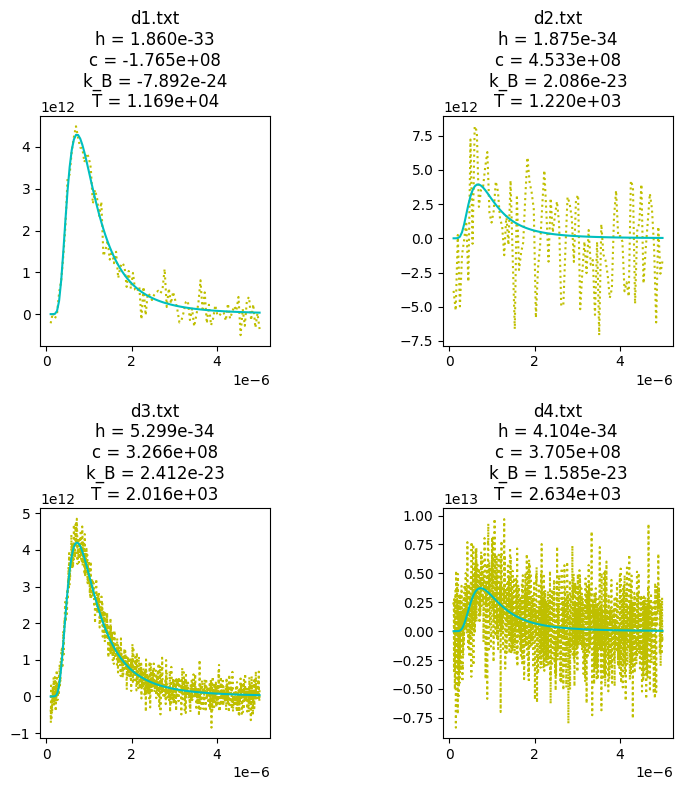

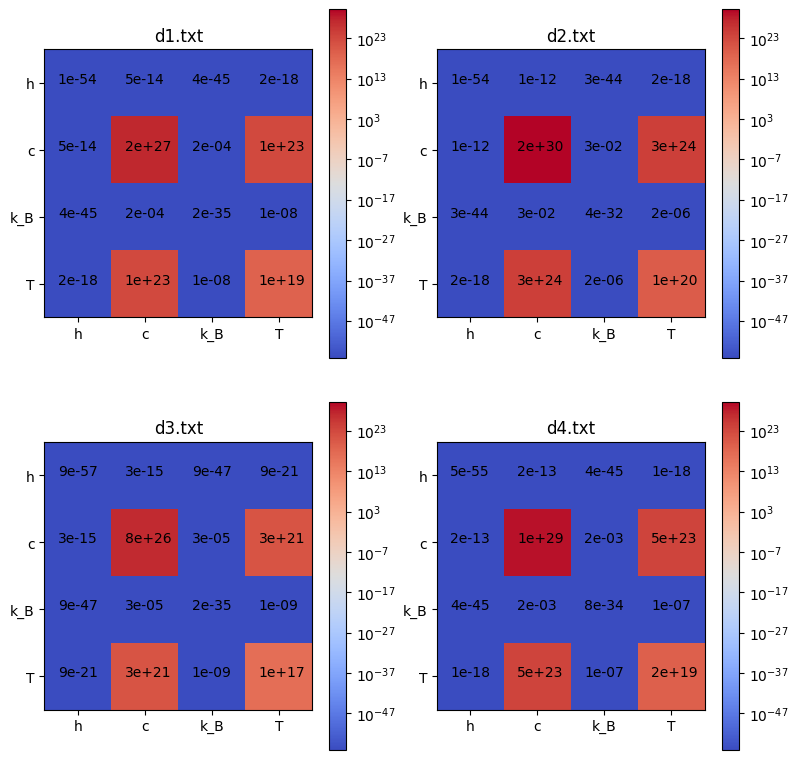

In [8]:
# Curve fit with all four parameters
@do_four
def regular_curve_fit(x: np.array, y: np.array) -> Tuple[np.array, np.array, str]:
    zk, cov = curve_fit(radiance, x, y, p0=(1e-34, 1e8, 1e-23, 1e3))
    
    return radiance(x, zk[0], zk[1], zk[2], zk[3]), cov, zk, ["h", "c", "k_B", "T"]

cov_regular, param_names = regular_curve_fit(data_array)
plot_cov_matrix(cov_regular, param_names)

/tmp/ipykernel_1228272/3291795101.py:3: RuntimeWarning: overflow encountered in exp
  return (2 * ((h * (c ** 2)) / l) / np.power(l, 4)) / (np.exp((h * c) / (l * k_B * T)) - 1)


Stddev Error:
['h', 'k_B', 'T']
d1.txt: [3.61136375e-35 1.35636640e-17 1.30307095e+09]
d2.txt: [3.13286645e-34 1.60730435e-16 1.64411544e+10]
d3.txt: [1.16681653e-35 5.23578772e-18 3.56489606e+08]
d4.txt: [1.30400634e-34 4.36648659e-17 3.96648716e+09]


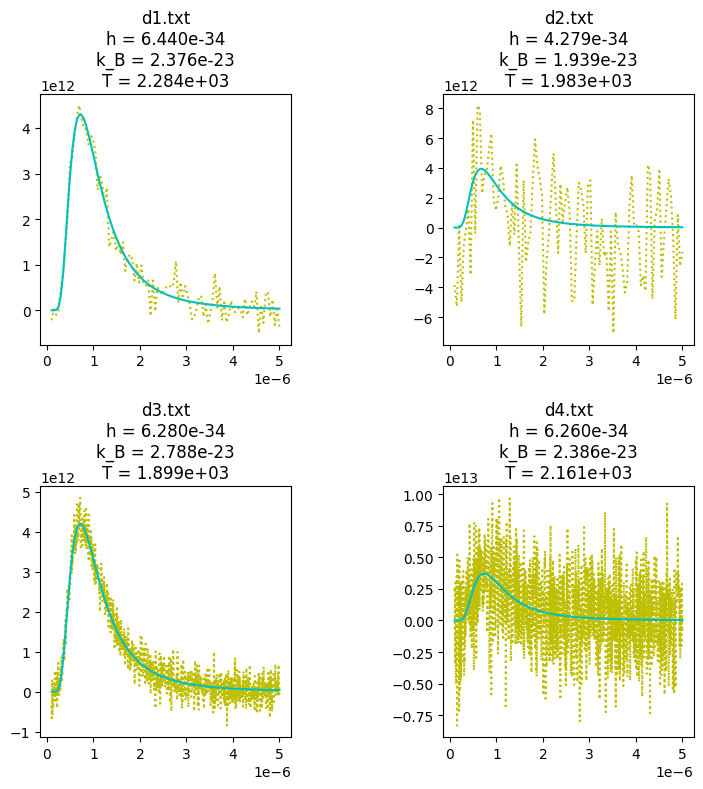

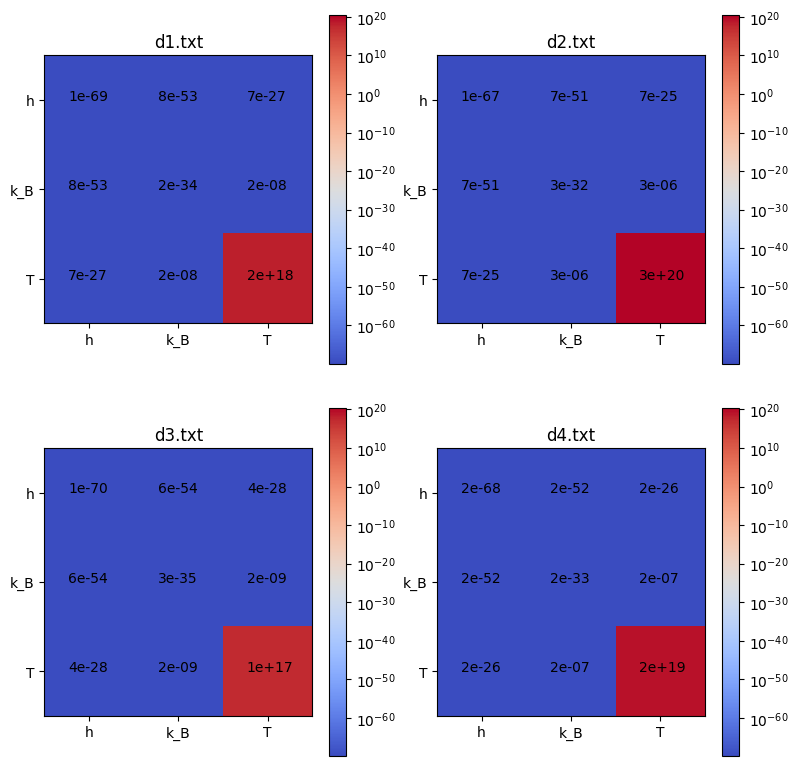

In [9]:
# Curve fit after removing c
@do_four
def curve_fit_three_params(x: np.array, y: np.array) -> Tuple[np.array, np.array, str]:
    radiance_3 = lambda x, h, k_B, T: radiance(x, h, 3e8, k_B, T)
    zk, cov = curve_fit(radiance_3, x, y, p0=(1e-34, 1e-23, 1e3))
    
    return radiance_3(x, zk[0], zk[1], zk[2]), cov, zk, ["h", "k_B", "T"]

cov_three_params, param_names = curve_fit_three_params(data_array)
plot_cov_matrix(cov_three_params, param_names)

Stddev Error:
['h', 'T']
d1.txt: [3.54772565e-35 1.73533804e+02]
d2.txt: [3.08738348e-34 1.61021063e+03]
d3.txt: [1.16079875e-35 5.67948497e+01]
d4.txt: [1.30179944e-34 6.22130163e+02]


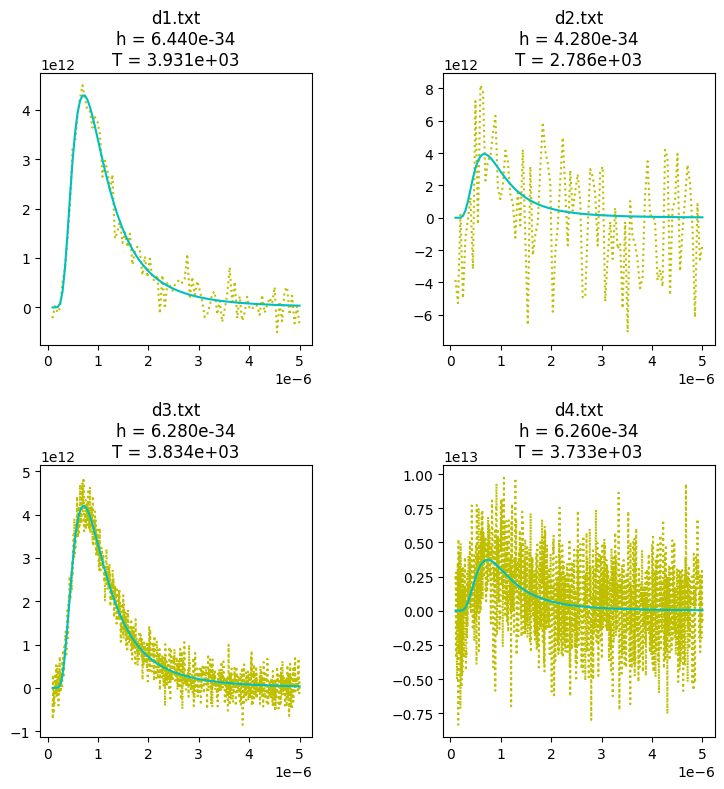

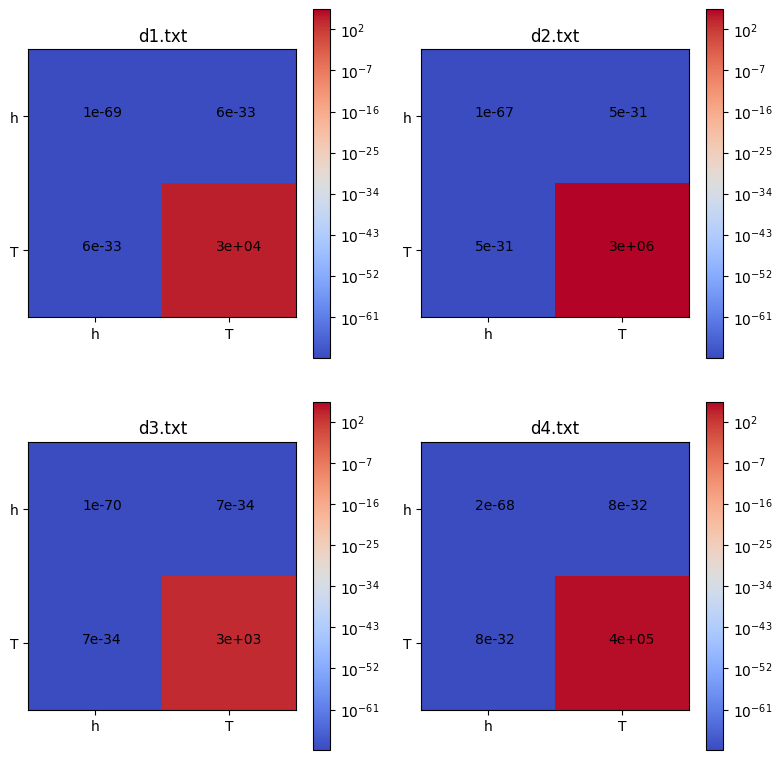

In [10]:
# Curve fit with only h and T
@do_four
def curve_fit_two_params(x: np.array, y: np.array) -> Tuple[np.array, np.array, str]:
    radiance_2 = lambda x, h, T: radiance(x, h, 3e8, 1.3806e-23, T)
    zk, cov = curve_fit(radiance_2, x, y, p0=(1e-34, 1e3))
    
    return radiance_2(x, zk[0], zk[1]), cov, zk, ["h", "T"]

cov_two_params, param_names = curve_fit_two_params(data_array)
plot_cov_matrix(cov_two_params, param_names)

Stddev Error:
d1.txt: [2.75998641e-36]
d2.txt: [3.43916234e-35]
d3.txt: [9.29560823e-37]
d4.txt: [1.07342812e-35]


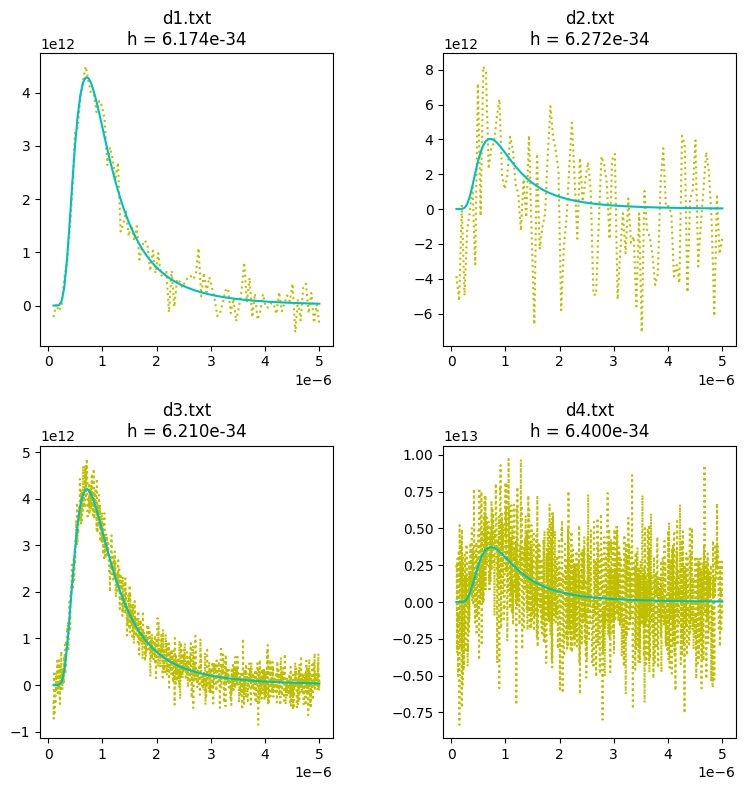

In [11]:
# Curve fit with only h
@do_four
def curve_fit_h(x: np.array, y: np.array) -> Tuple[np.array, np.array, str]:
    radiance_2 = lambda x, h: radiance(x, h, 3e8, 1.3806e-23, 3.8e3)
    zk, cov = curve_fit(radiance_2, x, y, p0=(1e-34))
    
    return radiance_2(x, zk[0]), cov, zk, ["h"]

cov_h, _ = curve_fit_h(data_array)

print("Stddev Error:")
for idx, cov in enumerate(cov_h):
    print(f"d{idx + 1}.txt:", np.sqrt(np.diag(cov)))

Stddev Error:
d1.txt: [1745378.97294078]
d2.txt: [21085310.43451432]
d3.txt: [585372.93431173]
d4.txt: [6760617.43978805]


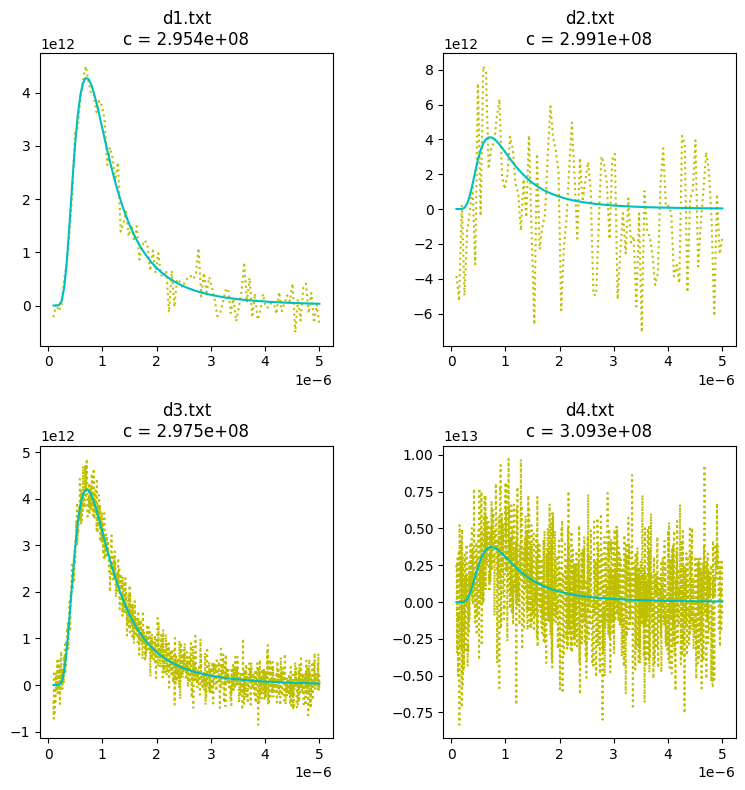

In [12]:
# Curve fit with only c
@do_four
def curve_fit_c(x: np.array, y: np.array) -> Tuple[np.array, np.array, str]:
    radiance_2 = lambda x, c: radiance(x, 6.25e-34, c, 1.3806e-23, 3.8e3)
    zk, cov = curve_fit(radiance_2, x, y, p0=(1e8))
    
    return radiance_2(x, zk[0]), cov, zk, ["c"]

cov_c, _ = curve_fit_c(data_array)

print("Stddev Error:")
for idx, cov in enumerate(cov_c):
    print(f"d{idx + 1}.txt:", np.sqrt(np.diag(cov)))

Stddev Error:
d1.txt: [4.97684948e-26]
d2.txt: [6.11334762e-25]
d3.txt: [1.66303302e-26]
d4.txt: [1.82584777e-25]


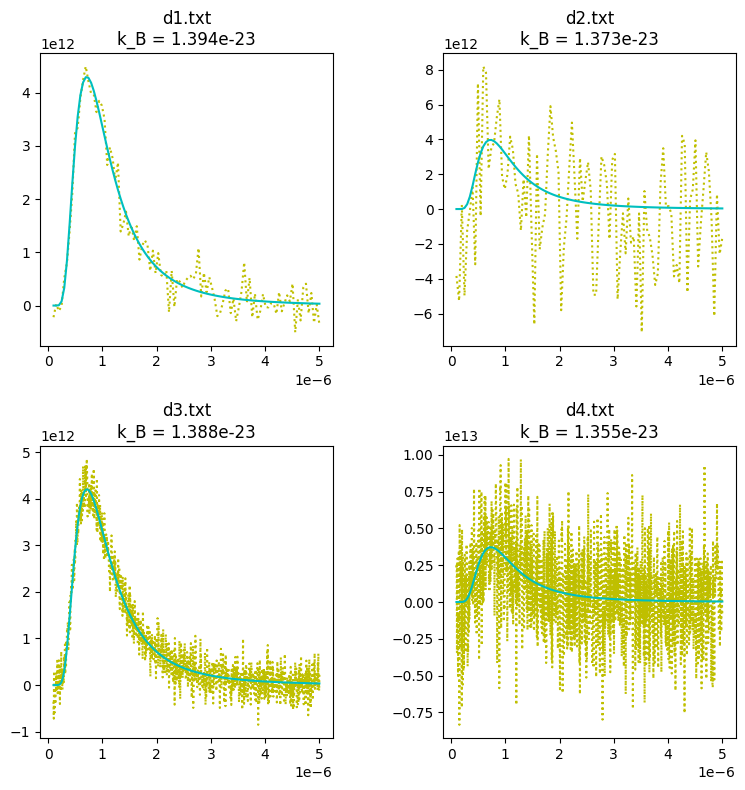

In [13]:
# Curve fit with only k_B
@do_four
def curve_fit_kb(x: np.array, y: np.array) -> Tuple[np.array, np.array, str]:
    radiance_2 = lambda x, k_B: radiance(x, 6.25e-34, 3e8, k_B, 3.8e3)
    zk, cov = curve_fit(radiance_2, x, y, p0=(1e-23))
    
    return radiance_2(x, zk[0]), cov, zk, ["k_B"]

cov_kb, _ = curve_fit_kb(data_array)

print("Stddev Error:")
for idx, cov in enumerate(cov_kb):
    print(f"d{idx + 1}.txt:", np.sqrt(np.diag(cov)))

/tmp/ipykernel_1228272/3291795101.py:3: RuntimeWarning: overflow encountered in exp
  return (2 * ((h * (c ** 2)) / l) / np.power(l, 4)) / (np.exp((h * c) / (l * k_B * T)) - 1)


Stddev Error:
d1.txt: [13.69839261]
d2.txt: [6.57961929e+09]
d3.txt: [4.57732375]
d4.txt: [50.25442788]


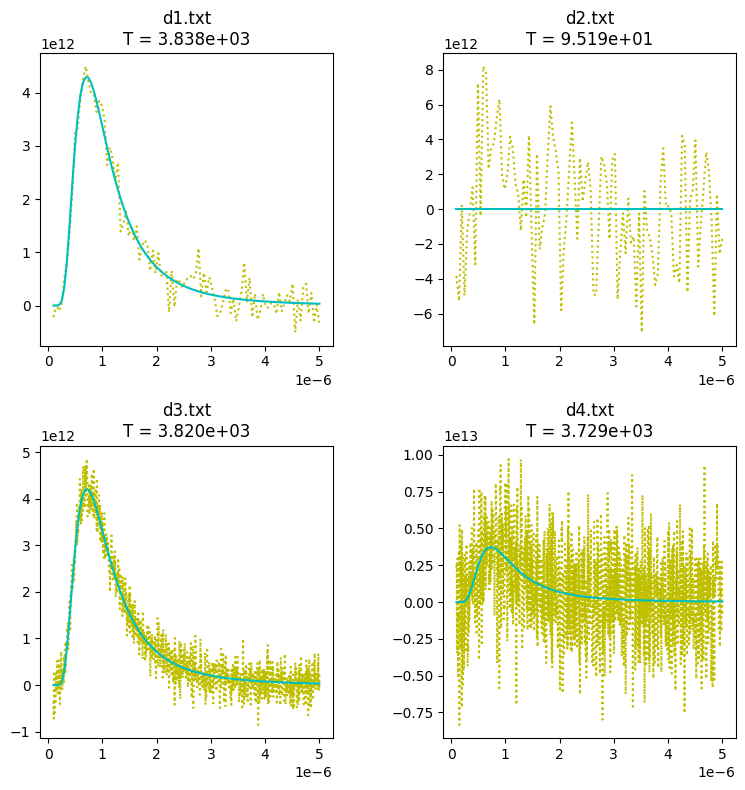

In [14]:
# Curve fit with only T
@do_four
def curve_fit_T(x: np.array, y: np.array) -> Tuple[np.array, np.array, str]:
    radiance_2 = lambda x, T: radiance(x, 6.25e-34, 3e8, 1.3806e-23, T)
    zk, cov = curve_fit(radiance_2, x, y, p0=(1e3))
    
    return radiance_2(x, zk[0]), cov, zk, ["T"]

cov_T, _ = curve_fit_T(data_array)

print("Stddev Error:")
for idx, cov in enumerate(cov_T):
    print(f"d{idx + 1}.txt:", np.sqrt(np.diag(cov)))

Stddev Error:
d1.txt: [12.88319899]
d2.txt: [55.46304327]
d3.txt: [3.99007386]
d4.txt: [15.48141678]


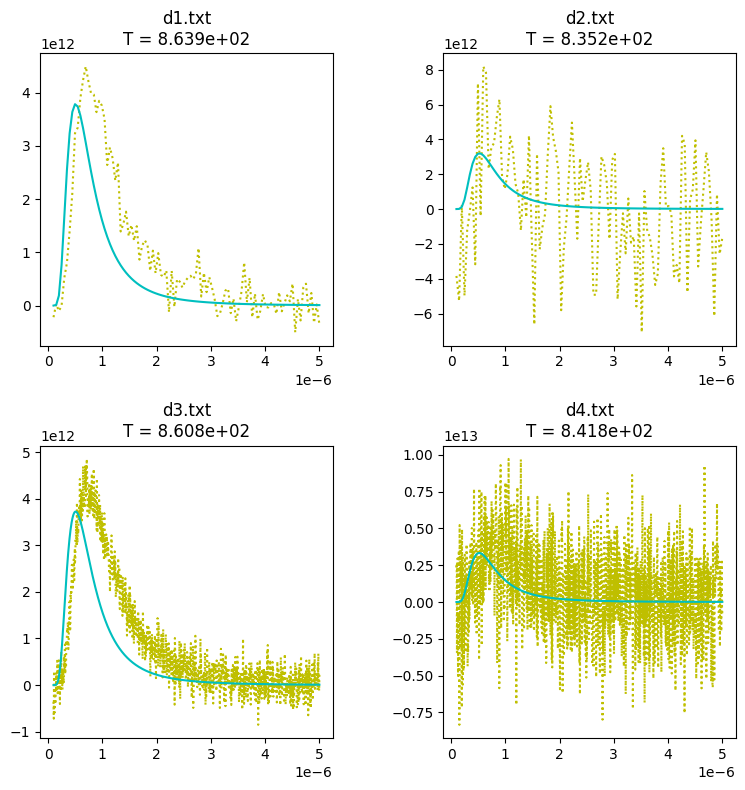

In [15]:
# Curve fit with for T with an invalid h
# The guess for T is a whole order off
@do_four
def curve_fit_invalid_h(x: np.array, y: np.array) -> Tuple[np.array, np.array, str]:
    radiance_2 = lambda x, T: radiance(x, 1e-34, 3e8, 1.3806e-23, T)
    zk, cov = curve_fit(radiance_2, x, y, p0=(1e3))
    
    return radiance_2(x, zk[0]), cov, zk, ["T"]

cov_invalid_h, _ = curve_fit_invalid_h(data_array)

print("Stddev Error:")
for idx, cov in enumerate(cov_invalid_h):
    print(f"d{idx + 1}.txt:", np.sqrt(np.diag(cov)))